In [2]:
# Spotify Popularity Prediction

This notebook builds a predictive model for Spotify track popularity (0-100) using audio and metadata features.

It includes:
- Data loading and cleaning
- Exploratory data analysis (EDA)
- Feature engineering (e.g., artist count, title signals)
- Modeling (Linear Regression, Random Forest, optional XGBoost)
- Evaluation (MAE, RMSE, R²)
- Visualizations (correlations, feature importances, SHAP, partial dependence)

Set the `DATASET_PATH` below if your file is located elsewhere.


SyntaxError: invalid character '²' (U+00B2) (2086219684.py, line 10)

In [4]:
# Paths
from pathlib import Path
DATASET_PATH = Path('/Users/anooptejthotapalli/Downloads/dataset-3-1.csv')
assert DATASET_PATH.exists(), f"Dataset not found at {DATASET_PATH}"

# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

# Load
df = pd.read_csv(DATASET_PATH)
print(df.shape)
df.head()


(114000, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [6]:
# Clean column names: fix possible line-wrapped header cells
# Sometimes CSVs from certain sources wrap header lines; we'll normalize columns.
df.columns = [c.strip().replace('\n', '').replace('  ', ' ') for c in df.columns]

# Rename common wrapped columns if present
rename_map = {
    'danceabi lity': 'danceability',
    'mod e': 'mode',
    'time_signatur e': 'time_signature',
}
df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)

# Drop unnamed index column if present
for col in df.columns:
    if col.lower().startswith('unnamed'):
        df.drop(columns=[col], inplace=True)
        break

print('Columns:', list(df.columns))
df.head()


Columns: ['track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


                     count           mean            std     min  \
popularity        114000.0      33.238535      22.305078   0.000   
duration_ms       114000.0  228029.153114  107297.712645   0.000   
danceability      114000.0       0.566800       0.173542   0.000   
energy            114000.0       0.641383       0.251529   0.000   
key               114000.0       5.309140       3.559987   0.000   
loudness          114000.0      -8.258960       5.029337 -49.531   
mode              114000.0       0.637553       0.480709   0.000   
speechiness       114000.0       0.084652       0.105732   0.000   
acousticness      114000.0       0.314910       0.332523   0.000   
instrumentalness  114000.0       0.156050       0.309555   0.000   
liveness          114000.0       0.213553       0.190378   0.000   
valence           114000.0       0.474068       0.259261   0.000   
tempo             114000.0     122.147837      29.978197   0.000   
time_signature    114000.0       3.904035       

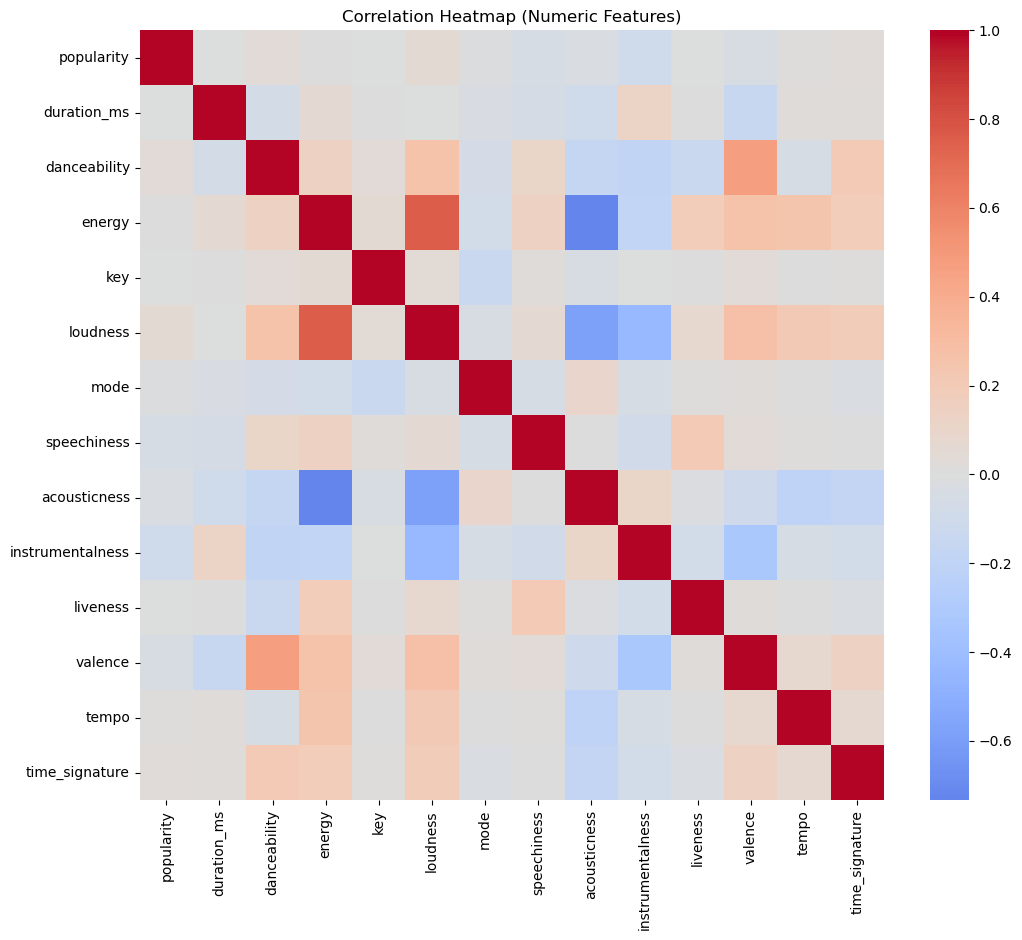

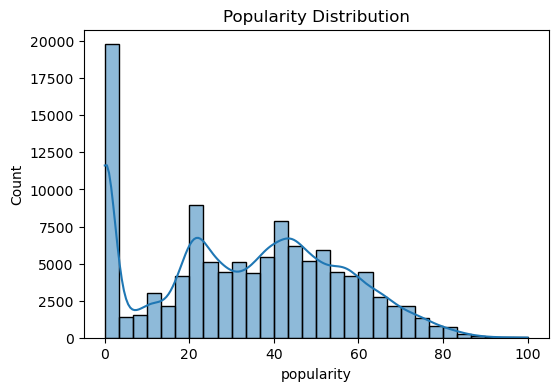

In [8]:
# Basic EDA
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
non_target_numeric = [c for c in numeric_cols if c != 'popularity']

print(df[numeric_cols].describe().T)

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()

# Popularity distribution
plt.figure(figsize=(6,4))
sns.histplot(df['popularity'], bins=30, kde=True)
plt.title('Popularity Distribution')
plt.show()


In [10]:
# Feature engineering
from sklearn.preprocessing import OneHotEncoder

# Derived features
if 'artists' in df.columns:
    df['num_artists'] = df['artists'].astype(str).str.split(';').apply(len)
else:
    df['num_artists'] = 1

if 'track_name' in df.columns:
    lower_titles = df['track_name'].astype(str).str.lower()
    df['title_len'] = lower_titles.str.len()
    df['title_has_feat'] = lower_titles.str.contains('feat|ft\.|with', regex=True).astype(int)
else:
    df['title_len'] = 0
    df['title_has_feat'] = 0

categorical_cols = []
if 'track_genre' in df.columns:
    categorical_cols.append('track_genre')

# One-hot encode single categorical (keep low cardinality)
if categorical_cols:
    enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ohe = enc.fit_transform(df[categorical_cols])
    ohe_cols = [f"{categorical_cols[0]}__{cat}" for cat in enc.categories_[0]]
    ohe_df = pd.DataFrame(ohe, columns=ohe_cols, index=df.index)
    df = pd.concat([df.drop(columns=categorical_cols), ohe_df], axis=1)

features = [c for c in df.columns if c not in ['popularity','track_id','artists','album_name','track_name']]
X = df[features]
y = df['popularity']
X.shape, y.shape


<>:13: SyntaxWarning: invalid escape sequence '\.'
<>:13: SyntaxWarning: invalid escape sequence '\.'
/var/folders/sm/1mmys55x6yz2z2s6pmtwqmcc0000gp/T/ipykernel_53040/2193360130.py:13: SyntaxWarning: invalid escape sequence '\.'
  df['title_has_feat'] = lower_titles.str.contains('feat|ft\.|with', regex=True).astype(int)


((114000, 131), (114000,))

In [12]:
# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape


((91200, 131), (22800, 131))

In [14]:
# Baseline and tree-based models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    print(f"{name}: MAE={mae:.3f} RMSE={rmse:.3f} R2={r2:.3f}")

best_model_name = max(results, key=lambda k: results[k]['R2'])
best_model = models[best_model_name]
print('Best model:', best_model_name)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


LinearRegression: MAE=13.987 RMSE=18.929 R2=0.274
RandomForest: MAE=10.045 RMSE=14.775 R2=0.558
Best model: RandomForest


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


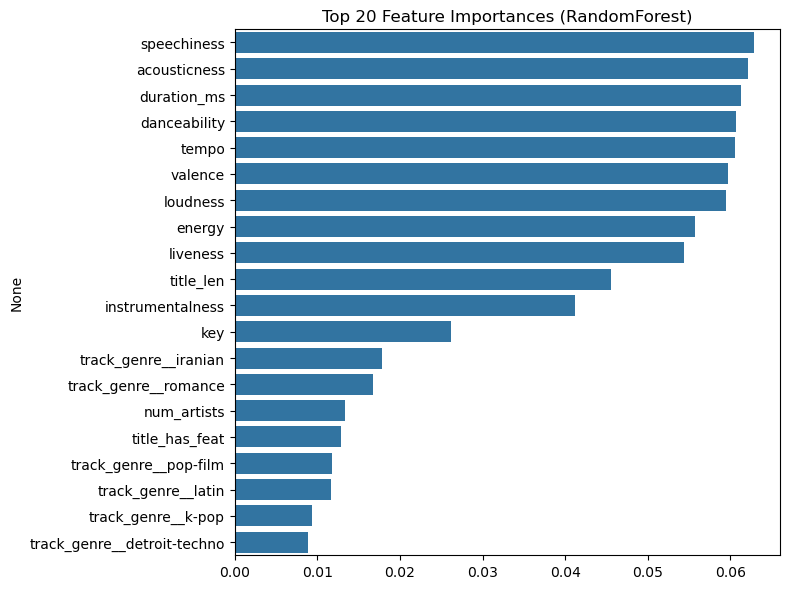

In [15]:
# Feature importance (for tree models)
importances = None
if hasattr(best_model, 'feature_importances_'):
    importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    top20 = importances.sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(x=top20.values, y=top20.index)
    plt.title(f'Top 20 Feature Importances ({best_model_name})')
    plt.tight_layout()
    plt.show()
else:
    print('Best model has no feature_importances_ attribute.')


In [ ]:
# SHAP explanations (optional; can be heavy on very large datasets)
!pip -q install shap >/dev/null
import shap

# Use a sample for speed
sample_idx = np.random.RandomState(42).choice(X_test.index, size=min(2000, len(X_test)), replace=False)
X_sample = X_test.loc[sample_idx]

explainer = None
if best_model_name == 'RandomForest':
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_sample)
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.tight_layout()
    plt.show()
else:
    # KernelExplainer fallback
    explainer = shap.KernelExplainer(best_model.predict, shap.sample(X_train, 200))
    shap_values = explainer.shap_values(X_sample)
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluation visualizations
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

preds = best_model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_test, preds)
print(f"Final ({best_model_name}) -> MAE={mae:.3f} RMSE={rmse:.3f} R2={r2:.3f}")

# Prediction vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, preds, alpha=0.3)
lims = [min(y_test.min(), preds.min()), max(y_test.max(), preds.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Prediction vs Actual')
plt.tight_layout()
plt.show()

# Residuals
residuals = y_test - preds
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residual (Actual - Predicted)')
plt.tight_layout()
plt.show()


In [ ]:
# Partial Dependence (selected features)
from sklearn.inspection import PartialDependenceDisplay

selected_features = [f for f in ['danceability','energy','acousticness','valence','tempo'] if f in X_train.columns]
if selected_features:
    fig, ax = plt.subplots(figsize=(10, 6))
    PartialDependenceDisplay.from_estimator(best_model, X_train, selected_features, ax=ax)
    plt.suptitle('Partial Dependence Plots')
    plt.tight_layout()
    plt.show()
else:
    print('Selected features not found for PDP.')


In [ ]:
# Save model
import joblib
MODEL_PATH = Path('../models/best_spotify_popularity_model.pkl')
joblib.dump(best_model, MODEL_PATH)
print('Saved model to', MODEL_PATH.resolve())
